# Problem Statement

HELP International, an international humanitarian NGO, has been able to raise around $10 million through awareness drives and funding programmes. CEO of this NGO wants to decide how to use this money strategically and effectively. Using the clustering algorithms we need to help CEO to decide the countries that are in the direst need of aid by categorising the countries using some socio-economic and health factors that determine the overall development of the country so that the CEO can focus on those countires the most.

In [ ]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import all required packages
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale the data
from sklearn.preprocessing import StandardScaler

#Improting the PCA module
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### 1. Reading and Understanding the Data

In [ ]:
# Import and read dataset
df_country = pd.read_csv('Country-data.csv')
df_country.head()

In [ ]:
df_country.shape

In [ ]:
df_country.info()

In [ ]:
df_country.describe()

In [ ]:
# Check for NaN values in dataset
print(df_country.isnull().values.any())
print(df_country.isnull().values.sum())

There are no NaN values in the dataset

In [ ]:
# Let's make sure that there are no duplicate rows in the dataset
sum(df_country.duplicated(subset = 'country')) == 0

There are no duplicate rows in the dataset

#### Split feature and response variables

In [ ]:
df_country.columns

In [343]:
# Putting feature variable to X
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
X = df_country[features]

# Putting response variable to y
response = 'country'
y = df_country[response]

#### Check for the correlation matrix

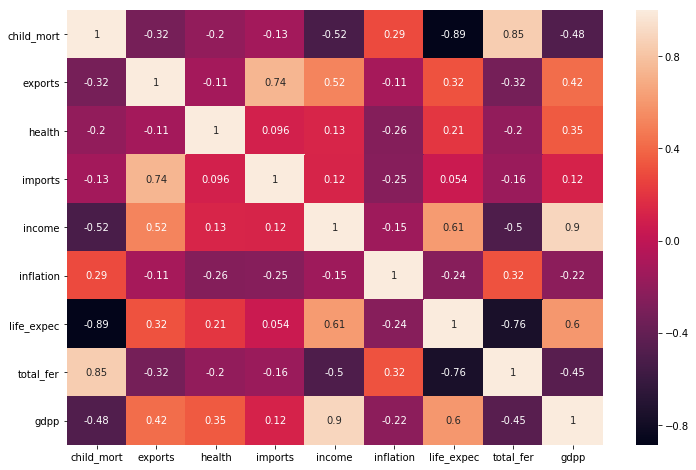

In [344]:
plt.figure(figsize = (12,8))
sns.heatmap(X.corr(),annot = True)

* Above heatmap clearly shows some variables with high correlation.
> * income and gdpp
> * child_mort and total_fer
> * imports and exports etc.
* Let's find out which variables have the highest and lowest correlation.

In [345]:
#creating correlation matrix for the given data
corrmat = np.corrcoef(X.transpose())

In [346]:
#Make a diagonal matrix with diagonal entry of Matrix corrmat
p=np.diagflat(corrmat.diagonal())

In [347]:
# subtract diagonal entries making all diagonals 0
corrmat_diag_zero = corrmat - p
print("max corr:",corrmat_diag_zero.max(), ", min corr: ", corrmat_diag_zero.min(),)


max corr: 0.895571433087532 , min corr:  -0.8866760973367759


In [348]:
# Retrieve the (i,j) index for which matrix has maximum value
ij_max = np.unravel_index(corrmat_diag_zero.argmax(), corrmat_diag_zero.shape)
print("ij_max",ij_max)
print("Maximum correlation :",corrmat_diag_zero[ij_max])

ij_max (4, 8)
Maximum correlation : 0.895571433087532


Highest correlation is between 'income' and 'gdpp'

In [349]:
# Retrieve the (i,j) index for which matrix has absolute minimum value
ij_min = np.unravel_index(np.absolute(corrmat).argmin(), corrmat.shape)
print("ij_min",ij_min)
print("Minimum correlation :",corrmat_diag_zero[ij_min])

ij_min (3, 6)
Minimum correlation : 0.054390534928787385


There is hardly any correlation between 'imports' and 'life_expec'

### 2. Principal Component Analysis

Since there is a high correlation between some variables, let's apply PCA to get the reduced numbers of variables which will account for and explain most the variance in correlation matrix pattern.

#### Standardize the Data

Let's first standardize the data before applying PCA

In [350]:
stand_X = StandardScaler().fit_transform(X)

In [351]:
X = pd.DataFrame(stand_X, columns = features)
X.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


#### Apply PCA

In [352]:
pca = PCA(svd_solver='randomized', random_state=100)

In [353]:
principalComponents = pca.fit_transform(X)

#### Now let's plot the principal components

In [354]:
df_pcs = pd.DataFrame({'Feature':features,
                       'PC1':pca.components_[0],
                       'PC2':pca.components_[1],
                       'PC3':pca.components_[2],
                       'PC4':pca.components_[3],
                       'PC5':pca.components_[4],
                       'PC6':pca.components_[5],
                       'PC7':pca.components_[6],
                       'PC8':pca.components_[7],
                       'PC9':pca.components_[8]})
df_pcs

,Feature,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,child_mort,-0.419519,0.192884,-0.029544,0.370653,-0.168970,0.200628,-0.079489,-0.682743,0.327542
1,exports,0.283897,0.613163,0.144761,0.003091,0.057616,-0.059333,-0.707303,-0.014197,-0.123082
2,health,0.150838,-0.243087,-0.596632,0.461897,0.518000,0.007276,-0.249831,0.072497,0.113088
3,imports,0.161482,0.671821,-0.299927,-0.071907,0.255376,-0.030032,0.592190,-0.028946,0.099037
4,income,0.398441,0.022536,0.301548,0.392159,-0.247150,0.160347,0.095562,0.352624,0.612982
5,inflation,-0.193173,-0.008404,0.642520,0.150442,0.714869,0.066285,0.104633,-0.011538,-0.025236
6,life_expec,0.425839,-0.222707,0.113919,-0.203797,0.108220,-0.601127,0.018486,-0.504664,0.294040
7,total_fer,-0.403729,0.155233,0.019549,0.378304,-0.135262,-0.750689,0.028826,0.293353,-0.026336
8,gdpp,0.392645,-0.046022,0.122977,0.531995,-0.180167,0.016779,0.242998,-0.249696,-0.625646


We'll plot original features on the first 2 principal components as axes

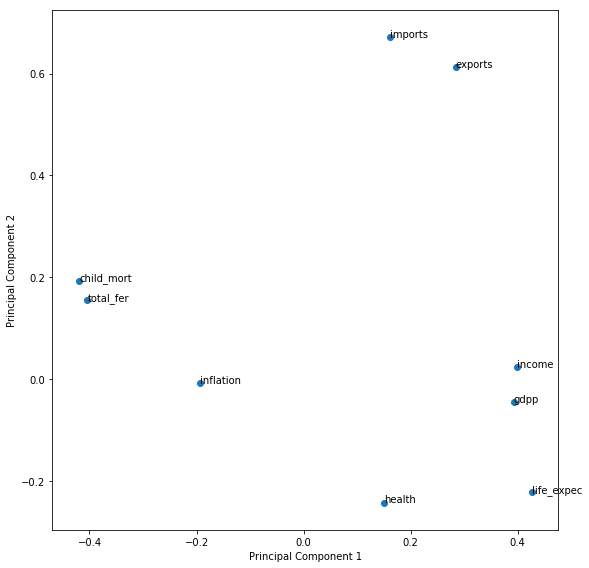

In [355]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_pcs.PC1, df_pcs.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(df_pcs.Feature):
    plt.annotate(txt, (df_pcs.PC1[i],df_pcs.PC2[i]))
plt.tight_layout()
plt.show()

Observations:
* First Principal Component has high weightage of - income, gdpp, life_expec
* Second Principal Component majorly has - imports and exports

#### Let's look at the screeplot to assess the number of principal components we would need for further analysis

Explained Variance

In [356]:
pca.explained_variance_

array([4.16057017, 1.55566165, 1.1774338 , 1.00077724, 0.66459866,
       0.224928  , 0.1141221 , 0.08884738, 0.06727787])

In [357]:
print("pca.explained_variance_ratio_: ",pca.explained_variance_ratio_.round(3)*100)

pca.explained_variance_ratio_:  [46.  17.2 13.  11.1  7.3  2.5  1.3  1.   0.7]


In [358]:
print(pca.explained_variance_ratio_.cumsum())

[0.4595174  0.63133365 0.76137624 0.87190786 0.94530998 0.97015232
 0.98275663 0.99256944 1.        ]


In [359]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([45.95, 63.13, 76.13, 87.18, 94.52, 97.  , 98.26, 99.24, 99.98])

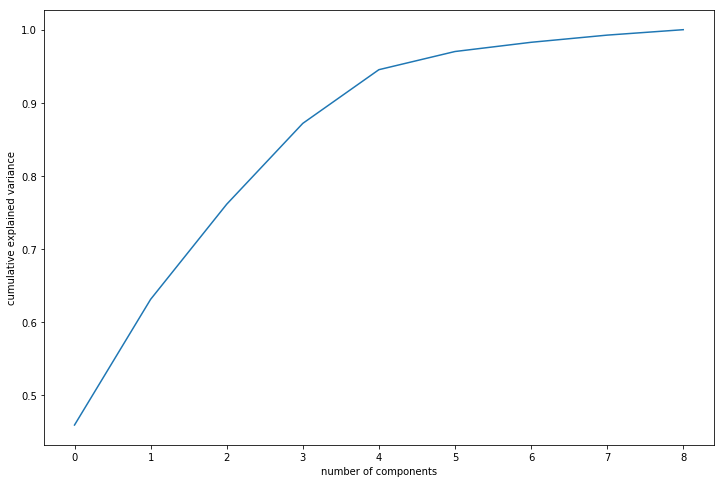

In [360]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Observations:
* After 4 principal components graph is almost flat.
* 4 principal components are able to explain the 87.18% of the variance in the dataset.

We'll choose 4 components for our modeling

In [361]:
pca_final = IncrementalPCA(n_components=4)

#### Basis transformation - get the data onto PCs

In [362]:
pca_final = pca_final.fit_transform(X)

In [363]:
pca_final.shape

(167, 4)

#### Create correlation matrix for the principal components

Let's verify that the principal components are not correlated

In [364]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(pca_final.transpose())

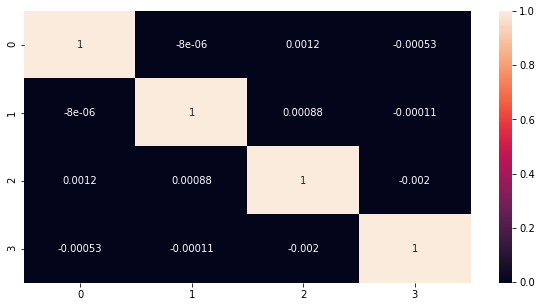

In [456]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (10,5))
sns.heatmap(corrmat,annot = True)

In [366]:
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.0011961925092544112 , min corr:  -0.002037829535552029


We see that correlations are indeed very close to 0, i.e., we have effectively removed multicollinearity from the dataset.

#### Create dataframe containing the 4 principal components

In [367]:
df_pca_final = pd.DataFrame(data = pca_final, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
df_pca_final.head()

,PC1,PC2,PC3,PC4
0,-2.913787,0.088354,0.721003,0.996699
1,0.429358,-0.587859,0.321052,-1.171193
2,-0.282988,-0.446657,-1.225135,-0.850127
3,-2.930969,1.699437,-1.521734,0.875966
4,1.031988,0.130488,0.192922,-0.844808


In [368]:
df_pca_final.shape

(167, 4)

In [369]:
df_country[['country']].head()

,country
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Antigua and Barbuda


In [370]:
df_post_pca = pd.concat([df_country[['country']], df_pca_final], axis = 1)
df_post_pca.head(10)

,country,PC1,PC2,PC3,PC4
0,Afghanistan,-2.913787,0.088354,0.721003,0.996699
1,Albania,0.429358,-0.587859,0.321052,-1.171193
2,Algeria,-0.282988,-0.446657,-1.225135,-0.850127
3,Angola,-2.930969,1.699437,-1.521734,0.875966
4,Antigua and Barbuda,1.031988,0.130488,0.192922,-0.844808
5,Argentina,0.028470,-1.756721,-0.793520,-0.052486
6,Armenia,-0.102849,-0.567476,-0.277669,-1.458321
7,Australia,2.339456,-1.998120,-0.237052,1.132490
8,Austria,2.973859,-0.734849,0.548421,1.192561
9,Azerbaijan,-0.180006,-0.393752,-0.864255,-0.426657


This is the final dataset we obtained after performing PCA and reducing the number of variables to 4.

Now, we can apply clustering algorithms on this stable dataset, but let's first treat the outliers present in it.

### 3. Outliers Analysis

In [371]:
df_post_pca.describe()

,PC1,PC2,PC3,PC4
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,2.659217e-17,1.429329e-17,-2.476396e-17,1.662011e-17
std,2.039726e+00,1.247144e+00,1.083371e+00,1.000238e+00
min,-4.878925e+00,-2.991196e+00,-5.590269e+00,-1.582161e+00
25%,-1.383574e+00,-7.481349e-01,-4.154744e-01,-7.901529e-01
50%,2.418370e-02,-9.344038e-02,1.937511e-01,-2.939462e-01
75%,1.224232e+00,5.568934e-01,5.140716e-01,7.090722e-01
max,6.918224e+00,6.685374e+00,2.857371e+00,3.150200e+00


Let's visualize these percentiles.

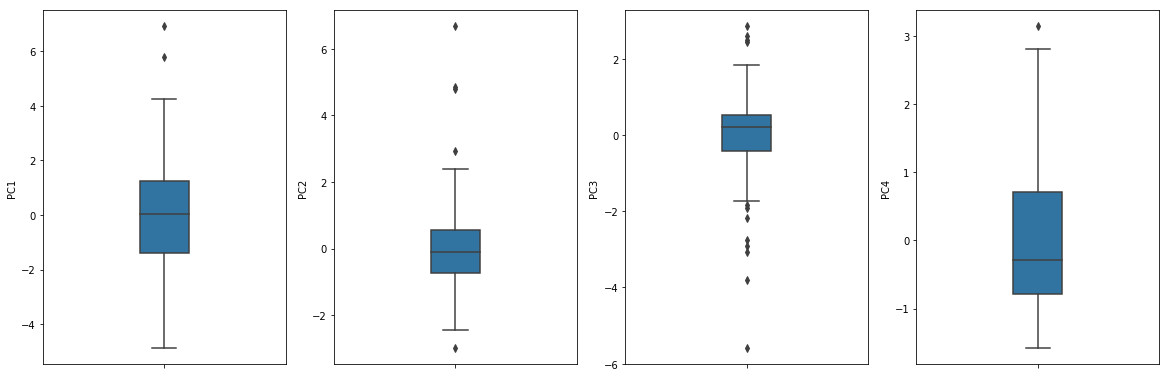

In [372]:
# Boxplots for outliers
    
plt.figure(figsize=(20,30))

i = 0
for pc in list(df_post_pca.columns[1:]):
    i+=1
    plt.subplot(4,4,i)
    ax = sns.boxplot(y=pc, width = 0.2, data = df_post_pca)

plt.show()

Clearly, few outliers are present in the data.

Let's also visualize them using swarmplots.

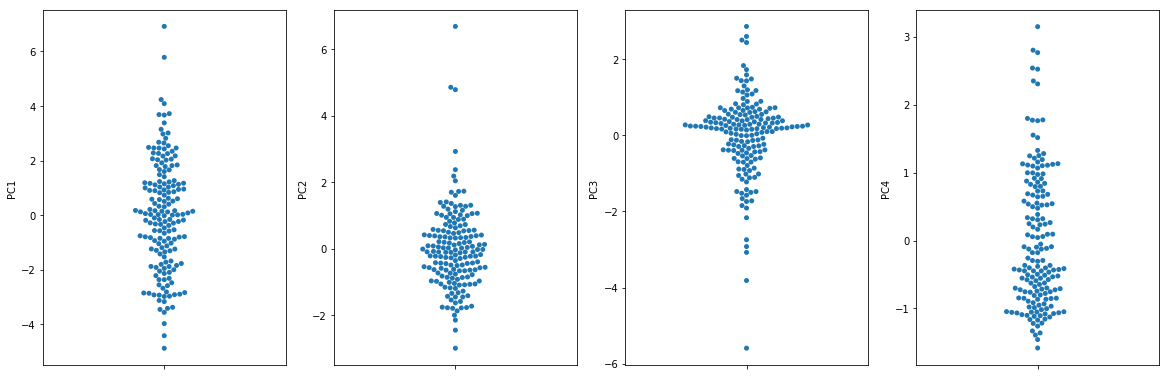

In [373]:
# Swarmplots for outliers

plt.figure(figsize=(20,30))

i = 0
for pc in list(df_post_pca.columns[1:]):
    i+=1
    plt.subplot(4,4,i)
    ax = sns.swarmplot(y=pc, data = df_post_pca)
    
plt.show()

#### Outliers Treatment

In [374]:
# Also parallely create a series of ouliers
outliers = pd.Series([])

In [375]:
# outlier treatment for PC1
Q1 = df_post_pca.PC1.quantile(0.25)
Q3 = df_post_pca.PC1.quantile(0.75)
IQR = Q3 - Q1

outliers = outliers.append(df_post_pca[(df_post_pca.PC1 < Q1 - 1.5*IQR) | (df_post_pca.PC1 > Q3 + 1.5*IQR)]['country'])
df_post_pca = df_post_pca[(df_post_pca.PC1 >= Q1 - 1.5*IQR) & (df_post_pca.PC1 <= Q3 + 1.5*IQR)]

In [376]:
# outlier treatment for PC2
Q1 = df_post_pca.PC2.quantile(0.25)
Q3 = df_post_pca.PC2.quantile(0.75)
IQR = Q3 - Q1

outliers = outliers.append(df_post_pca[(df_post_pca.PC2 < Q1 - 1.5*IQR) | (df_post_pca.PC2 > Q3 + 1.5*IQR)]['country'])
df_post_pca = df_post_pca[(df_post_pca.PC2 >= Q1 - 1.5*IQR) & (df_post_pca.PC2 <= Q3 + 1.5*IQR)]

In [377]:
# outlier treatment for PC3
Q1 = df_post_pca.PC3.quantile(0.25)
Q3 = df_post_pca.PC3.quantile(0.75)
IQR = Q3 - Q1

outliers = outliers.append(df_post_pca[(df_post_pca.PC3 < Q1 - 1.5*IQR) | (df_post_pca.PC3 > Q3 + 1.5*IQR)]['country'])
df_post_pca = df_post_pca[(df_post_pca.PC3 >= Q1 - 1.5*IQR) & (df_post_pca.PC3 <= Q3 + 1.5*IQR)]

In [378]:
# outlier treatment for PC4
Q1 = df_post_pca.PC4.quantile(0.25)
Q3 = df_post_pca.PC4.quantile(0.75)
IQR = Q3 - Q1

outliers = outliers.append(df_post_pca[(df_post_pca.PC4 < Q1 - 1.5*IQR) | (df_post_pca.PC4 > Q3 + 1.5*IQR)]['country'])
df_post_pca = df_post_pca[(df_post_pca.PC4 >= Q1 - 1.5*IQR) & (df_post_pca.PC4 <= Q3 + 1.5*IQR)]

In [379]:
df_post_pca.shape

(149, 5)

In [380]:
outliers.count()

18

In [381]:
outliers

91                Luxembourg
133                Singapore
98                     Malta
131               Seychelles
159            United States
23                    Brunei
81                  Kiribati
82                    Kuwait
87                   Lesotho
88                   Liberia
101    Micronesia, Fed. Sts.
113                  Nigeria
115                     Oman
123                    Qatar
128             Saudi Arabia
140                Sri Lanka
157     United Arab Emirates
163                Venezuela
dtype: object

Also, let's divide the original dataset into two dataframes with and without the outliers.

In [382]:
df_country.head()
print(df_country.shape)

(167, 10)


In [383]:
df_country_without_outliers = df_country.drop(df_country.index[outliers.index])

In [384]:
df_country_without_outliers.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [385]:
df_country_without_outliers.shape

(149, 10)

In [386]:
df_country_with_outliers = df_country[~df_country.index.isin(df_country_without_outliers.index)]

In [387]:
df_country_with_outliers.shape

(18, 10)

In [388]:
df_country_with_outliers

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300
81,Kiribati,62.7,13.3,11.30,79.9,1730,1.520,60.7,3.84,1490
82,Kuwait,10.8,66.7,2.63,30.4,75200,11.200,78.2,2.21,38500
87,Lesotho,99.7,39.4,11.10,101.0,2380,4.150,46.5,3.30,1170
88,Liberia,89.3,19.1,11.80,92.6,700,5.470,60.8,5.02,327
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100
101,"Micronesia, Fed. Sts.",40.0,23.5,14.20,81.0,3340,3.800,65.4,3.46,2860
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.000,60.5,5.84,2330
115,Oman,11.7,65.7,2.77,41.2,45300,15.600,76.1,2.90,19300


#### Now, let's again check the boxplots after the outliers treatment.

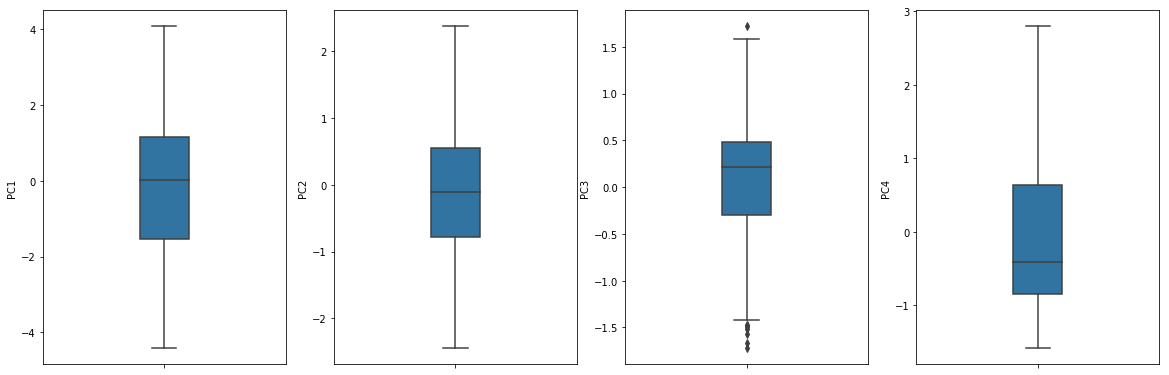

In [389]:
# Boxplots for outliers
    
plt.figure(figsize=(20,30))

i = 0
for pc in list(df_post_pca.columns[1:]):
    i+=1
    plt.subplot(4,4,i)
    ax = sns.boxplot(y=pc, width = 0.2, data = df_post_pca)

plt.show()

Outliers are now removed from the dataset successfully.

#### Let's plot these 4 PCs on scatter plot

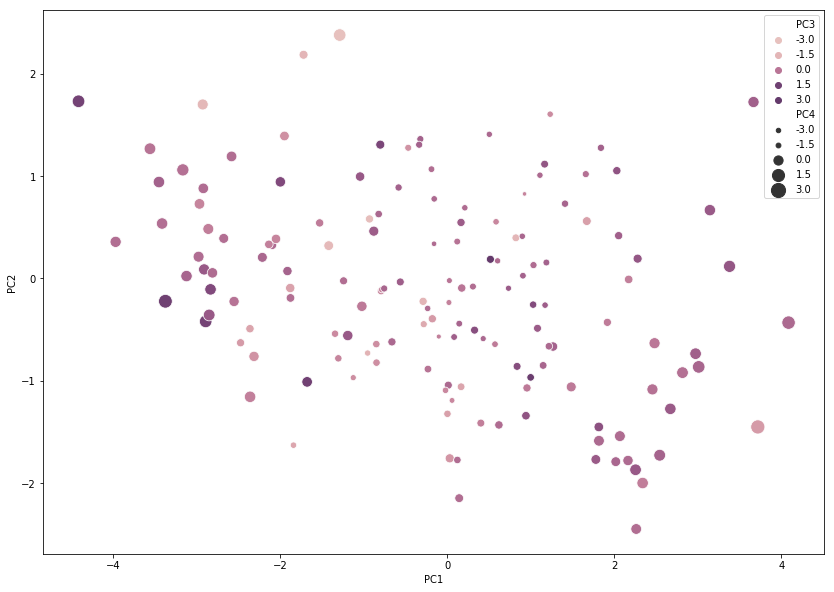

In [390]:
# PC1 = x-axis
# PC2 = y-axis
# PC3 = color
# PC4 = size

fig = plt.figure(figsize = (14,10))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=df_post_pca.PC1, 
                y=df_post_pca.PC2, 
                hue=df_post_pca.PC3, 
                size=df_post_pca.PC4, 
                sizes=(20, 200), 
                color=".9",
                palette=cmap)
plt.legend(loc='upper right')

### 4. Clustering

Let's first check if the data is suitable for clustering.

#### Hopkins Statistics

In [391]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [392]:
df_cluster_X = df_post_pca[df_post_pca.columns[1:]]

In [393]:
hopkins(df_cluster_X)

0.7783846967425031

Hopkins value of greater than 0.7 shows that the data has a higher tendency to cluster.

Now, let's cluster the data using K-Means cluster.

But first find out the optimal number of K would be needed for the algorithm. Let's do it using silhouette analysis.

#### Silhouette Analysis

In [394]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k).fit(df_cluster_X)
    sse_.append([k, silhouette_score(df_cluster_X, kmeans.labels_)])

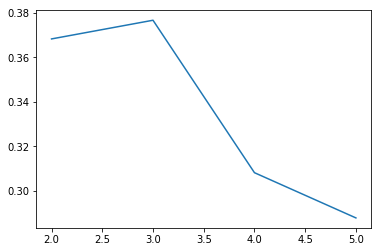

In [395]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

From this graph, it's cleary visible that value of K between 2-to-4 would be a good choice for clustering.

Now let's determine K using elbow method

#### Elbow Analysis

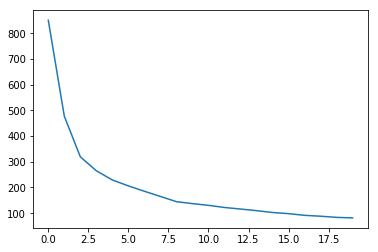

In [396]:
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_cluster_X)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

The elbow curve also shows a value between 2-to-4 would be optimal value of K.

Let's cluster the data with K = 3

#### K-Means Clustering with K = 3

In [397]:
# Kmeans with K=3
df_cluster_X_K3 = df_cluster_X
kmean3 = KMeans(n_clusters = 3, max_iter=50)
kmean3.fit(df_cluster_X_K3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [398]:
# Getting the cluster centers
C_K3 = kmean3.cluster_centers_

In [399]:
# Predicting the clusters
labels_K3 = kmean3.predict(df_cluster_X_K3)

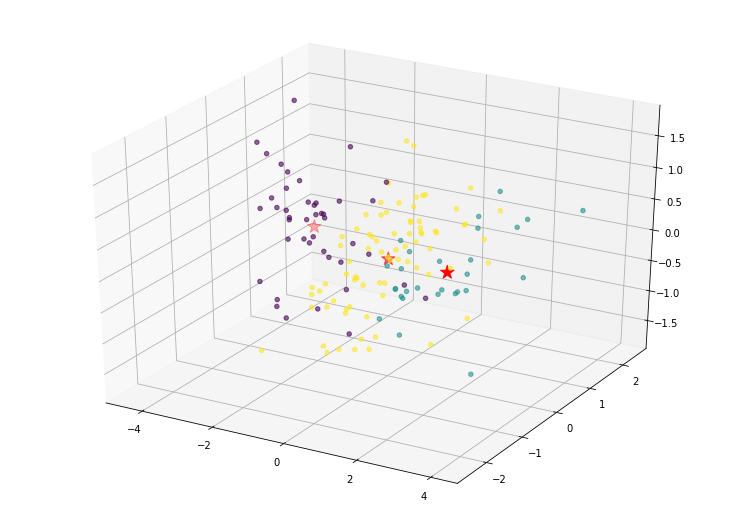

In [400]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,7))
ax = Axes3D(fig)
ax.scatter(df_cluster_X_K3.iloc[:,0].values, 
           df_cluster_X_K3.iloc[:,1].values, 
           df_cluster_X_K3.iloc[:,2].values, c=labels_K3, cmap='viridis', alpha=0.6)
ax.scatter(C_K3[:, 0], C_K3[:, 1], C_K3[:, 2], marker='*', c='r', s=200)

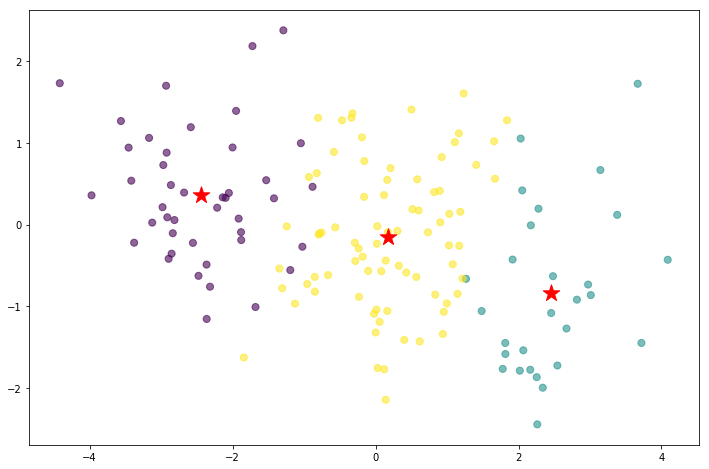

In [401]:
fig = plt.figure(figsize = (12,8))
plt.scatter(df_cluster_X_K3.iloc[:,0].values, df_cluster_X_K3.iloc[:,1].values, 
            c=labels_K3, s=50, cmap='viridis', alpha=0.6)
plt.scatter(C_K3[:, 0], C_K3[:, 1], c='r', marker='*', s=300);

#### Add 'ClusterID' to origininal dataset without outliers

In [402]:
df_country_without_outliers_k3 = df_country_without_outliers
df_country_without_outliers_k3.index = pd.RangeIndex(len(df_country_without_outliers_k3.index))

In [403]:
df_country_without_outliers_k3 = pd.concat([df_country_without_outliers_k3, pd.Series(kmean3.labels_)], axis=1)

In [404]:
df_country_without_outliers_k3.columns = ['country', 'child_mort', 'exports', 
                                          'health', 'imports', 'income', 'inflation', 
                                          'life_expec', 'total_fer', 'gdpp', 'ClusterID']

In [405]:
df_country_without_outliers_k3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


In [406]:
df_country_without_outliers_k3.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
144,Uzbekistan,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,2
145,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,2
146,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,2
147,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0
148,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,0


All cluster ids are properly assigned to the original dataset (without outliers)

#### Perform mean analysis for all columns per cluster

In [407]:
km3_clusters_child_mort = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).child_mort.mean())
km3_clusters_exports = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).exports.mean())
km3_clusters_health = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).health.mean())

km3_clusters_imports = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).imports.mean())
km3_clusters_income = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).income.mean())
km3_clusters_inflation = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).inflation.mean())

km3_clusters_life_expec = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).life_expec.mean())
km3_clusters_total_fer = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).total_fer.mean())
km3_clusters_gdpp = pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).gdpp.mean())

df_km3_clusters_mean = pd.concat([pd.Series([0,1,2]), 
                                  km3_clusters_child_mort, 
                                  km3_clusters_exports, 
                                  km3_clusters_health,
                                  km3_clusters_imports,
                                  km3_clusters_income,
                                  km3_clusters_inflation,
                                  km3_clusters_life_expec,
                                  km3_clusters_total_fer,
                                  km3_clusters_gdpp], axis=1)

df_km3_clusters_mean.columns = ['ClusterID', 'child_mort_mean', 'exports_mean', 'health_mean', 'imports_mean', 
                                'income_mean','inflation_mean', 'life_expec_mean', 'total_fer_mean', 'gdpp_mean']

df_km3_clusters_mean.head()

,ClusterID,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,92.732558,29.604884,6.069535,39.495349,4077.511628,10.460116,59.379070,5.055349,1977.558140
1,1,4.521429,45.200000,9.670714,43.389286,37360.714286,1.154571,80.289286,1.740714,40603.571429
2,2,22.135897,40.183192,6.223718,47.273922,11697.051282,6.989987,72.805128,2.281667,6012.717949


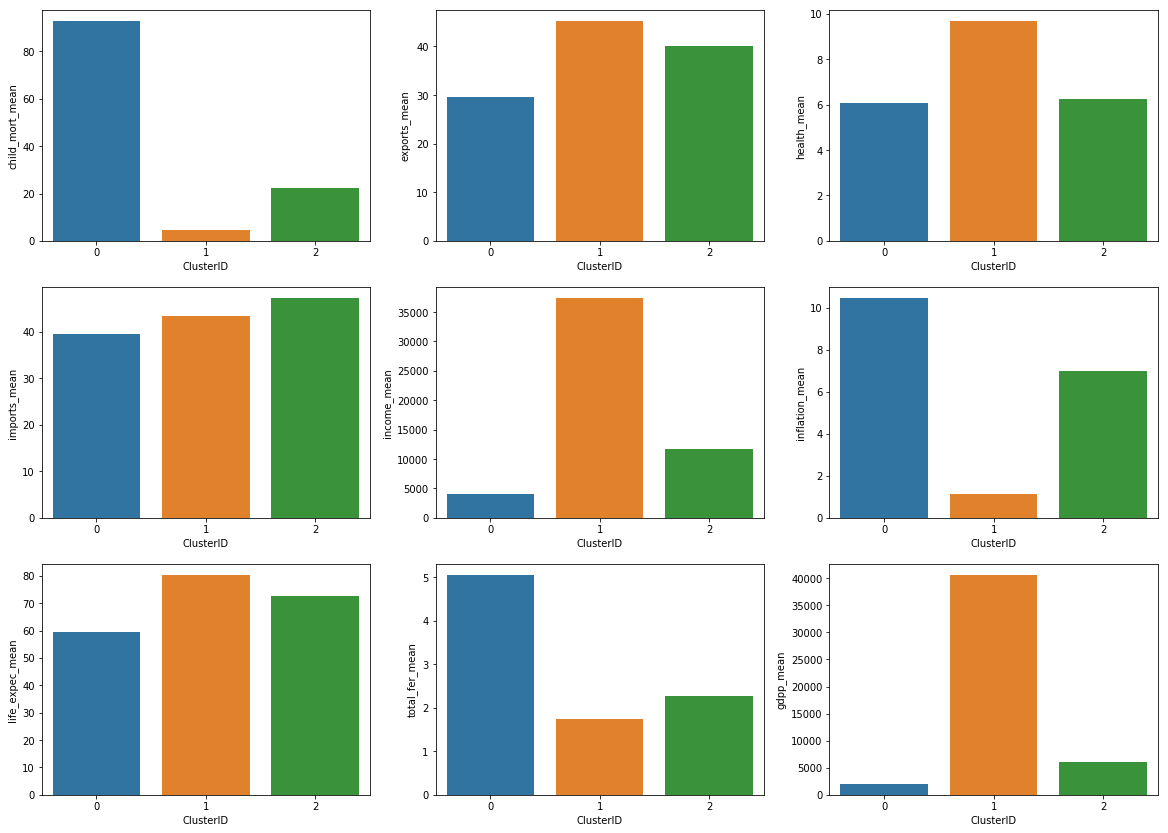

In [408]:
plt.figure(figsize=(20,45))

i = 0
for col in list(df_km3_clusters_mean.columns[1:]):
    i+=1
    plt.subplot(9,3,i)
    sns.barplot(x=df_km3_clusters_mean.ClusterID, y=df_km3_clusters_mean[col])
    
plt.show()

Observations:
* From the above barplots we can see that cluster 0 and cluster 1 have contrasting features. Let's compare them.

| Feature  |Cluster 1  | Cluster 0 |
|---|---|---|
| child_mort_mean  | Low  | High  |
| health_mean  | High  | Low  |
| income_mean | High  | Low  |
| inflation_mean  | Low | High  |
| total_fer_mean  | Low  | High  |
| gdpp_mean  | High  | Low  |

* Above table shows that based on some socio-economic and health factors the countries in cluster 0 are in direst need of aid.
* Whereas countries in cluster 1 seems to be developed kind of nations which don't need any aid.

With K=3 we are getting good cluster results, but still let's try clustering with K = 4 to see if we can get better results.

#### K-Means Clustering with K = 4

In [409]:
# Kmeans with K=4
df_cluster_X_K4 = df_cluster_X
kmean4 = KMeans(n_clusters = 4, max_iter=50)
kmean4.fit(df_cluster_X_K4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [410]:
# Getting the cluster centers
C_K4 = kmean4.cluster_centers_

In [411]:
# Predicting the clusters
labels_K4 = kmean4.predict(df_cluster_X_K4)

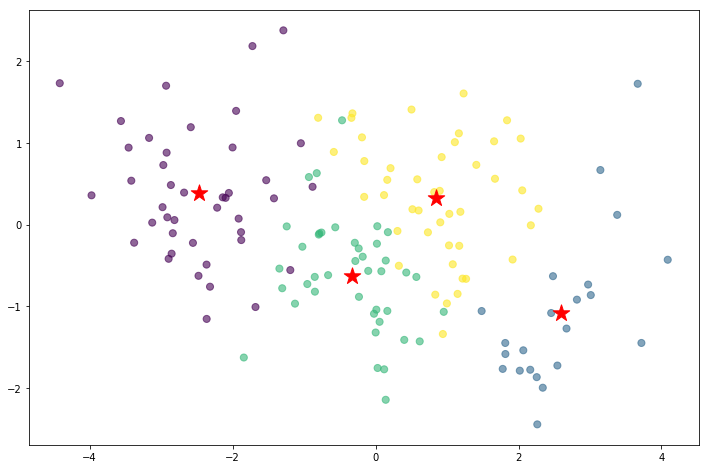

In [412]:
fig = plt.figure(figsize = (12,8))
plt.scatter(df_cluster_X_K4.iloc[:,0].values, df_cluster_X_K4.iloc[:,1].values, 
            c=labels_K4, s=50, cmap='viridis', alpha=0.6)
plt.scatter(C_K4[:, 0], C_K4[:, 1], c='r', marker='*', s=300);

#### Add 'ClusterID' to origininal dataset without outliers

In [413]:
df_country_without_outliers_k4 = df_country_without_outliers
df_country_without_outliers_k4.index = pd.RangeIndex(len(df_country_without_outliers_k4.index))

In [414]:
df_country_without_outliers_k4 = pd.concat([df_country_without_outliers_k4, pd.Series(kmean4.labels_)], axis=1)

In [415]:
df_country_without_outliers_k4.columns = ['country', 'child_mort', 'exports', 
                                          'health', 'imports', 'income', 'inflation', 
                                          'life_expec', 'total_fer', 'gdpp', 'ClusterID']

In [416]:
df_country_without_outliers_k4.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3


In [417]:
df_country_without_outliers_k4.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
144,Uzbekistan,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,2
145,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,2
146,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,3
147,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0
148,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,0


All cluster ids are properly assigned to the original dataset (without outliers)

#### Perform mean analysis for all columns per cluster

In [418]:
km4_clusters_child_mort = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).child_mort.mean())
km4_clusters_exports = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).exports.mean())
km4_clusters_health = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).health.mean())

km4_clusters_imports = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).imports.mean())
km4_clusters_income = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).income.mean())
km4_clusters_inflation = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).inflation.mean())

km4_clusters_life_expec = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).life_expec.mean())
km4_clusters_total_fer = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).total_fer.mean())
km4_clusters_gdpp = pd.DataFrame(df_country_without_outliers_k4.groupby(["ClusterID"]).gdpp.mean())

df_km4_clusters_mean = pd.concat([pd.Series([0,1,2,3]), 
                                  km4_clusters_child_mort, 
                                  km4_clusters_exports, 
                                  km4_clusters_health,
                                  km4_clusters_imports,
                                  km4_clusters_income,
                                  km4_clusters_inflation,
                                  km4_clusters_life_expec,
                                  km4_clusters_total_fer,
                                  km4_clusters_gdpp], axis=1)

df_km4_clusters_mean.columns = ['ClusterID', 'child_mort_mean', 'exports_mean', 'health_mean', 'imports_mean', 
                                'income_mean','inflation_mean', 'life_expec_mean', 'total_fer_mean', 'gdpp_mean']

df_km4_clusters_mean.head()

,ClusterID,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,94.061905,29.371667,6.013810,39.623810,3872.214286,10.313929,59.192857,5.067143,1917.500000
1,1,4.159091,42.018182,10.177727,39.268182,39850.000000,1.340136,80.990909,1.805455,45281.818182
2,2,28.185366,29.097293,5.616585,34.367461,10198.292683,9.204537,71.914634,2.541220,5060.878049
3,3,14.613636,52.770455,7.055682,60.531818,15371.363636,4.256318,74.177273,1.985455,9243.090909


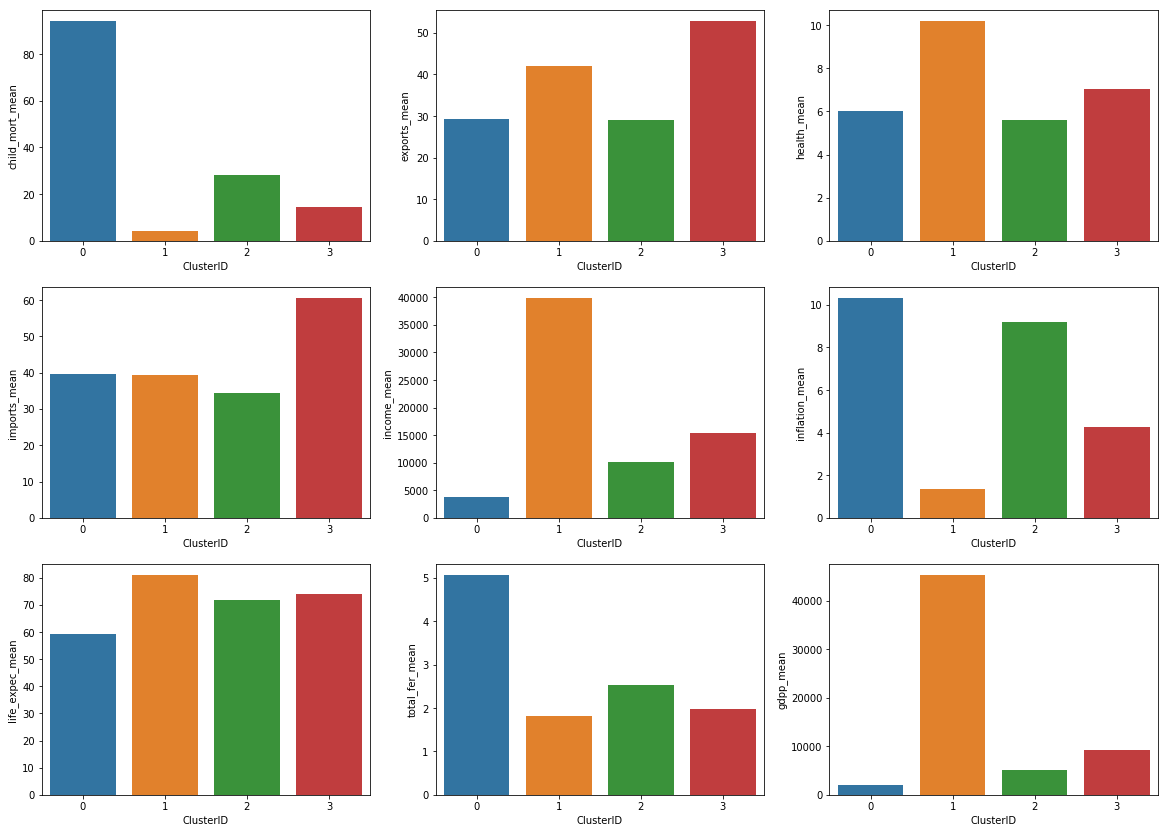

In [419]:
plt.figure(figsize=(20,45))

i = 0
for col in list(df_km4_clusters_mean.columns[1:]):
    i+=1
    plt.subplot(9,3,i)
    sns.barplot(x=df_km4_clusters_mean.ClusterID, y=df_km4_clusters_mean[col])
    
plt.show()

Observations:
* From the above barplots we can see that cluster 0 and cluster 1 have contrasting features.
* Cluster 0 shows countries which need aid and cluster 1 shows the developed countries.

* However, we can also see that bars of cluster 3 and cluster 4 are of similar lenghts which  means they can be in the same clusters.
* This proves with K=4 we are not getting as good clusters as we were getting with K=3.

* So, we will consider K=3 as the optimum numbers of clusters needed to analyse this dataset.

Now, let's verify the same thing using hierarchical clustering.

#### Hierarchical Clustering

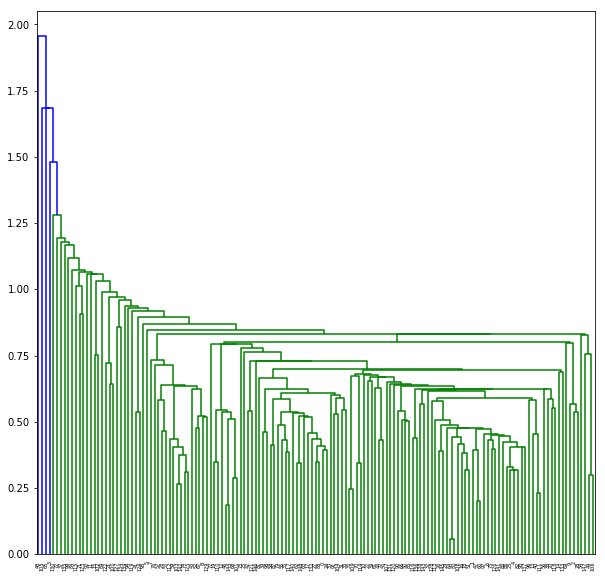

In [420]:
# heirarchical clustering with single linkage
plt.figure(figsize=(10,10))
mergings = linkage(df_cluster_X, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

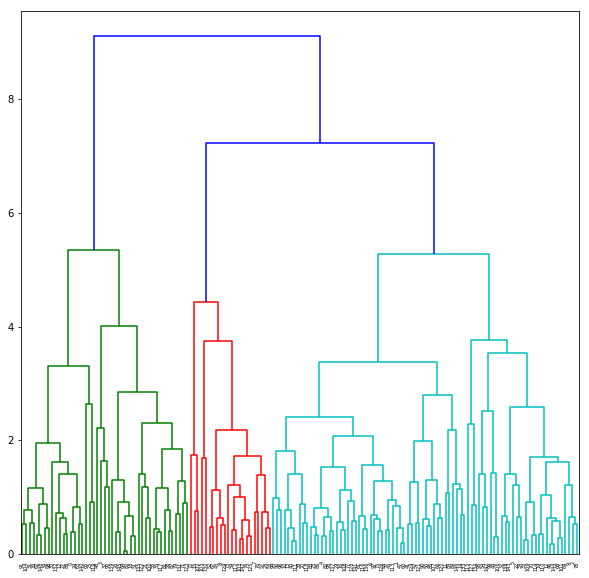

In [421]:
# heirarchical clustering with complete linkage
plt.figure(figsize=(10,10))
mergings = linkage(df_cluster_X, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Observations:
* Around threshold value of 6, we get 3 clean clusters.
* Hierarchical clustering also verifies the same thing which we determined using K-Means clustering.

Add 'ClusterID' to origininal dataset without outliers

In [422]:
df_country_without_outliers_hcluster = df_country_without_outliers
df_country_without_outliers_hcluster.index = pd.RangeIndex(len(df_country_without_outliers_hcluster.index))

In [423]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 3).reshape(-1,))
df_country_without_outliers_hcluster = pd.concat([df_country_without_outliers_hcluster, clusterCut], axis=1)

In [424]:
df_country_without_outliers_hcluster.columns = ['country', 'child_mort', 'exports', 
                                                'health', 'imports', 'income', 'inflation', 
                                                'life_expec', 'total_fer', 'gdpp', 'ClusterID']

In [425]:
df_country_without_outliers_hcluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1


In [426]:
df_country_without_outliers_hcluster.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
144,Uzbekistan,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,1
145,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0
146,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
147,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1
148,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,0


All cluster ids are properly assigned to the original dataset (without outliers)

#### Perform mean analysis for all columns per cluster

In [427]:
hc3_clusters_child_mort = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).child_mort.mean())
hc3_clusters_exports = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).exports.mean())
hc3_clusters_health = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).health.mean())

hc3_clusters_imports = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).imports.mean())
hc3_clusters_income = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).income.mean())
hc3_clusters_inflation = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).inflation.mean())

hc3_clusters_life_expec = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).life_expec.mean())
hc3_clusters_total_fer = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).total_fer.mean())
hc3_clusters_gdpp = pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).gdpp.mean())

df_hc3_clusters_mean = pd.concat([pd.Series([0,1,2]), 
                                  hc3_clusters_child_mort, 
                                  hc3_clusters_exports, 
                                  hc3_clusters_health,
                                  hc3_clusters_imports,
                                  hc3_clusters_income,
                                  hc3_clusters_inflation,
                                  hc3_clusters_life_expec,
                                  hc3_clusters_total_fer,
                                  hc3_clusters_gdpp], axis=1)

df_hc3_clusters_mean.columns = ['ClusterID', 'child_mort_mean', 'exports_mean', 'health_mean', 'imports_mean', 
                                'income_mean','inflation_mean', 'life_expec_mean', 'total_fer_mean', 'gdpp_mean']

df_hc3_clusters_mean.head()

,ClusterID,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,85.942222,35.058222,6.024222,47.093333,4108.511111,8.704111,59.857778,4.718000,1950.755556
1,1,22.948780,38.669256,6.368537,44.115438,13075.853659,7.392244,73.229268,2.342195,7401.743902
2,2,4.159091,42.018182,10.177727,39.268182,39850.000000,1.340136,80.990909,1.805455,45281.818182


Now, let's plot the chart

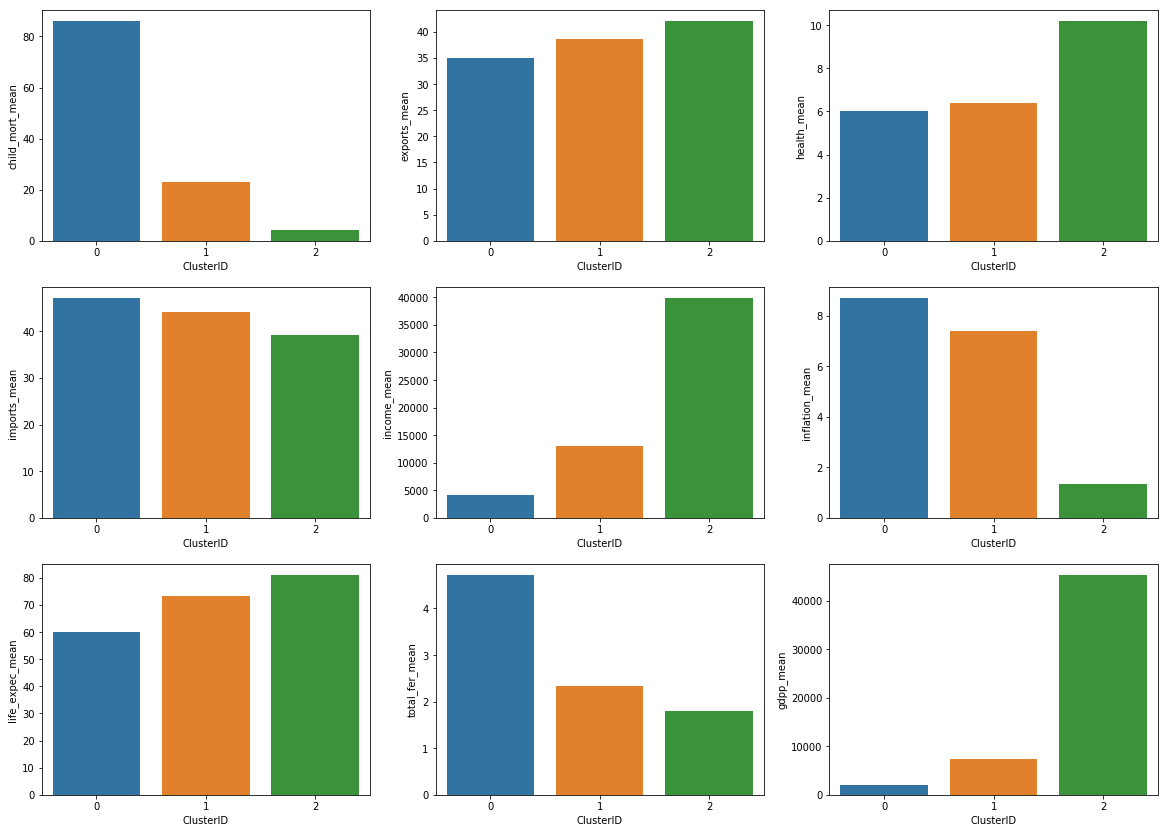

In [428]:
plt.figure(figsize=(20,45))

i = 0
for col in list(df_hc3_clusters_mean.columns[1:]):
    i+=1
    plt.subplot(9,3,i)
    sns.barplot(x=df_hc3_clusters_mean.ClusterID, y=df_hc3_clusters_mean[col])
    
plt.show()

Observations:
* The results are very similar to what we get with K-Means clustering with K=3.
* So, we can finally confirm that 3 different clusters of the countries gives us the better results.
* And based on this we can decide countries in which countries should be provided with the aid.

Let's find out the number of countries falling into the cluster of countries which need aid (both K-Means and hierarchical clustering).

In [429]:
print('cluster1 = ', pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).count()).country[0])
print('cluster2 = ', pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).count()).country[1])
print('cluster3 = ', pd.DataFrame(df_country_without_outliers_k3.groupby(["ClusterID"]).count()).country[2])

cluster1 =  43
cluster2 =  28
cluster3 =  78


43 countries would need aid (K-Means analysis).

In [430]:
print('cluster1 = ', pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).count()).country[0])
print('cluster2 = ', pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).count()).country[1])
print('cluster3 = ', pd.DataFrame(df_country_without_outliers_hcluster.groupby(["ClusterID"]).count()).country[2])

cluster1 =  45
cluster2 =  82
cluster3 =  22


45 countries would need aid (Hierarchical clustering analysis).

We can see both K-Means cluster and hierarchical cluster contain almost the same number of countries which need aid.

But before getting a final list of countries which would need aid, let's first merge outliers to our final clusters.

#### Merging outliers

In [431]:
# Here is a list of outliers countries
df_country_with_outliers

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300
81,Kiribati,62.7,13.3,11.30,79.9,1730,1.520,60.7,3.84,1490
82,Kuwait,10.8,66.7,2.63,30.4,75200,11.200,78.2,2.21,38500
87,Lesotho,99.7,39.4,11.10,101.0,2380,4.150,46.5,3.30,1170
88,Liberia,89.3,19.1,11.80,92.6,700,5.470,60.8,5.02,327
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100
101,"Micronesia, Fed. Sts.",40.0,23.5,14.20,81.0,3340,3.800,65.4,3.46,2860
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.000,60.5,5.84,2330
115,Oman,11.7,65.7,2.77,41.2,45300,15.600,76.1,2.90,19300


* From the bar charts above (displaying the mean analysis), we can see 'child_mort_mean', 'income_mean' and 'gdpp_mean' clearly distinguish between the three clusters.
* So, let's use on of these variables to merge outliers to the clusters.

In [432]:
# Let's use income_mean to merge outliers to clusters.
# Country with income_mean closest to one of the three cluster's income_mean would assigned to that particular cluster.

def closest_mean(income, cluster):
    '''Return the clusterID of the closest mean'''
    
    c0 = abs(income - cluster.income[0])
    c1 = abs(income - cluster.income[1])
    c2 = abs(income - cluster.income[2])
    
    if (c0 < c1) and (c0 < c2):
        closest_cluster = 0
    elif (c1 < c0) and (c1 < c2):
        closest_cluster = 1
    else:
        closest_cluster = 2

    return closest_cluster

1. Outlier merging with result of K-Means clustering

In [433]:
df_country_with_outliers_k3 = df_country_with_outliers

df_country_with_outliers_k3['ClusterID'] = df_country_with_outliers_k3['income'].apply(
                                            lambda i : closest_mean(i, km3_clusters_income)) 

df_country_with_outliers_k3

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,1
81,Kiribati,62.7,13.3,11.30,79.9,1730,1.520,60.7,3.84,1490,0
82,Kuwait,10.8,66.7,2.63,30.4,75200,11.200,78.2,2.21,38500,1
87,Lesotho,99.7,39.4,11.10,101.0,2380,4.150,46.5,3.30,1170,0
88,Liberia,89.3,19.1,11.80,92.6,700,5.470,60.8,5.02,327,0
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,1
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,1
101,"Micronesia, Fed. Sts.",40.0,23.5,14.20,81.0,3340,3.800,65.4,3.46,2860,0
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.000,60.5,5.84,2330,0
115,Oman,11.7,65.7,2.77,41.2,45300,15.600,76.1,2.90,19300,1


In [434]:
kmeans_final_cluster = pd.concat([df_country_without_outliers_k3, df_country_with_outliers_k3], axis=0)

kmeans_final_cluster.index = pd.RangeIndex(len(kmeans_final_cluster.index))

In [435]:
kmeans_final_cluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


In [436]:
kmeans_final_cluster.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
162,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,1
163,Sri Lanka,11.2,19.6,2.94,26.8,8560,22.800,74.4,2.20,2810,2
164,United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.500,76.5,1.87,35000,1
165,United States,7.3,12.4,17.90,15.8,49400,1.220,78.7,1.93,48400,1
166,Venezuela,17.1,28.5,4.91,17.6,16500,45.900,75.4,2.47,13500,2


In [437]:
kmeans_final_cluster.shape

(167, 11)

2. Outlier merging with result of hierarchical clustering

In [438]:
df_country_with_outliers_hc = df_country_with_outliers

df_country_with_outliers_hc['ClusterID'] = df_country_with_outliers_hc['income'].apply(
                                            lambda i : closest_mean(i, hc3_clusters_income)) 

df_country_with_outliers_hc

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,2
81,Kiribati,62.7,13.3,11.30,79.9,1730,1.520,60.7,3.84,1490,0
82,Kuwait,10.8,66.7,2.63,30.4,75200,11.200,78.2,2.21,38500,2
87,Lesotho,99.7,39.4,11.10,101.0,2380,4.150,46.5,3.30,1170,0
88,Liberia,89.3,19.1,11.80,92.6,700,5.470,60.8,5.02,327,0
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,2
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,2
101,"Micronesia, Fed. Sts.",40.0,23.5,14.20,81.0,3340,3.800,65.4,3.46,2860,0
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.000,60.5,5.84,2330,0
115,Oman,11.7,65.7,2.77,41.2,45300,15.600,76.1,2.90,19300,2


In [439]:
hierarchical_final_cluster = pd.concat([df_country_without_outliers_hcluster, df_country_with_outliers_hc], axis=0)

hierarchical_final_cluster.index = pd.RangeIndex(len(hierarchical_final_cluster.index))

In [440]:
hierarchical_final_cluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1


In [441]:
hierarchical_final_cluster.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
162,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,2
163,Sri Lanka,11.2,19.6,2.94,26.8,8560,22.800,74.4,2.20,2810,0
164,United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.500,76.5,1.87,35000,2
165,United States,7.3,12.4,17.90,15.8,49400,1.220,78.7,1.93,48400,2
166,Venezuela,17.1,28.5,4.91,17.6,16500,45.900,75.4,2.47,13500,1


In [442]:
hierarchical_final_cluster.shape

(167, 11)

Let's find out the final list of countries falling into the cluster of countries which need aid (both K-Means and hierarchical clustering).

In [450]:
print(pd.DataFrame(kmeans_final_cluster.groupby(["ClusterID"]).count()).country[0])

48


K-Means analysis shows 48 countries would need aid.

In [444]:
print(pd.DataFrame(hierarchical_final_cluster.groupby(["ClusterID"]).count()).country[0])

51


Hierarchical clustering analysis shows 51 countries would need aid.

#### List of countries which would need aid (based on K-Means Clustering)

In [449]:
county_need_aid_km = kmeans_final_cluster.groupby(['ClusterID']).get_group(0)
county_need_aid_km

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0
21,Botswana,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,0
24,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0
25,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0
27,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0
30,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0
31,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,0
35,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,0


#### List of countries which would need aid (based on Hierarchical Clustering)

In [452]:
county_need_aid_hc = hierarchical_final_cluster.groupby(["ClusterID"]).get_group(0)
county_need_aid_hc

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0
18,Bhutan,42.7,42.50,5.20,70.7,6420,5.990,72.1,2.38,2180,0
21,Botswana,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,0
24,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0
25,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0
26,Cambodia,44.4,54.10,5.68,59.5,2520,3.120,66.1,2.88,786,0
27,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0
30,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0
